In [1]:
import pandas as pd
import time
from datetime import date, timedelta, datetime
import numpy as np
from scipy.stats import norm
import scipy.ndimage.filters
import re
import json
import matplotlib.pyplot as plt
import csv 
import os
import folium
import branca.colormap as cm
from folium.plugins import MarkerCluster
from folium import plugins
import ast
import math
import pickle
import sys

from helper import * # File containig some helper functions
from maps import *
from plots import *
from event_detection import *
from event_localization import *
from const import *

# [Link to interactive visualisation](https://nbviewer.jupyter.org/github/brunowicht/ada_project/blob/master/project/project.ipynb)

<div style="background-color:gray;padding:10px;margin:10px;color:white">
**Run cell below to load necessary data**
</div>

In [2]:
print("Loading df_tag...")
df_tag = pd.read_csv("../../twitter_dataset/cleaned_hashtag.csv", sep=';', encoding="utf-8", low_memory=False)

print("Loading group_hashtags...")
group_hashtags = pd.read_csv("../../twitter_dataset/hashtag_grouped.csv", sep=";", index_col=[0], usecols=[0, 1, 2])
group_hashtags.tweets_idx = group_hashtags.tweets_idx.apply(lambda s: ast.literal_eval(s))

print("Loading dic_tag_days...")
pickle_in = open("../../twitter_dataset/dic_tag_days.pickle","rb")
dic_tag_days = pickle.load(pickle_in)
pickle_in.close()
print("Done")

Loading df_tag...
Loading group_hashtags...
Loading dic_tag_days...
Done


Definition of some constants relative to the dataset

# 0. Understanding the dataset

Before starting any kind of data analysis, we first have to review the content of our dataset and understand its meaning better. To do this, we use the data sample and the schema provided with the dataset.

## 0.1. Dataset structure
Let us first read the `schema.txt` file to understand what fields our dataset contains.

In [3]:
schema = pd.read_table('twitter-swisscom/schema.txt', delimiter='    ', engine='python',
                       names=['Field name', 'Type', 'Specification', 'Unsigned', 'Optional field', 'Format'] )
schema

Field name          Type    Specification  Unsigned Optional field  \
1               id    bigint(20)              NaN  UNSIGNED             No   
2           userId    bigint(20)              NaN  UNSIGNED             No   
3        createdAt     timestamp              NaN       NaN             No   
4             text          text  utf8_unicode_ci       NaN             No   
5        longitude         float              NaN       NaN            Yes   
6         latitude         float              NaN       NaN            Yes   
7          placeId   varchar(25)  utf8_general_ci       NaN            Yes   
8        inReplyTo    bigint(20)              NaN  UNSIGNED            Yes   
9           source       int(10)              NaN  UNSIGNED             No   
10       truncated        bit(1)              NaN       NaN             No   
11   placeLatitude         float              NaN       NaN            Yes   
12  placeLongitude         float              NaN       NaN            Yes   
13      sourceName  varchar(255)  utf8_general_ci       NaN            Yes   
14       sourceUrl  varchar(255)  utf8_general_ci       NaN            Yes   
15        userName  varchar(200)  utf8_general_ci       NaN            Yes   
16      screenName  varchar(200)  utf8_general_ci       NaN            Yes   
17  followersCount       int(10)              NaN  UNSIGNED            Yes   
18    friendsCount       int(10)              NaN  UNSIGNED            Yes   
19   statusesCount       int(10)              NaN  UNSIGNED            Yes   
20    userLocation  varchar(200)  utf8_general_ci       NaN            Yes   

                 Format  
1                  None  
2                  None  
3   0000-00-00 00:00:00  
4                  None  
5                   NaN  
6                   NaN  
7                   NaN  
8                   NaN  
9                  None  
10                 None  
11                  NaN  
12                  NaN  
13                  NaN  
14                  NaN  
15                  NaN  
16                  NaN  
17                  NaN  
18                  NaN  
19                  NaN  
20                  NaN

The `schema.txt` contains information about each field in our dataset. We see that there are 20 possible fields for a tweet, but many of them are optional, so most tweets probably haver fewer specified field than that.

Here are the fields that will be the most useful:
- userId: to know who posted the tweet
- createdAt: to know when the tweet was posted
- text: content of the tweet
- longitude and latitude: to know from where the tweet was posted


## 0.2. Dataset contents
Now, let us have a look at the actual content of our dataset using the provided sample.

In [4]:
sample_df = pd.read_csv('twitter-swisscom/sample.tsv', encoding='utf-8', sep='\t', escapechar='\\', 
                        index_col='id', names=schema['Field name'], quoting=csv.QUOTE_NONE, na_values='N')
sample_df.head()

userId            createdAt  \
id                                                            
776522983837954049  735449229028675584  2016-09-15 20:48:01   
776523000636203010          2741685639  2016-09-15 20:48:05   
776523045200691200           435239151  2016-09-15 20:48:15   
776523058404290560           503244217  2016-09-15 20:48:18   
776523058504925185           452805259  2016-09-15 20:48:18   

                                                                 text  \
id                                                                      
776522983837954049           se lo dici tu... https://t.co/x7Qm1VHBKL   
776523000636203010                            https://t.co/noYrTnqmg9   
776523045200691200  @BesacTof @Leonid_CCCP Tu dois t'engager en si...   
776523058404290560  @Mno0or_Abyat اشوف مظاهرات على قانون العمل الج...   
776523058504925185  Greek night #geneve (@ Emilios in Genève) http...   

                    longitude  latitude           placeId     inReplyTo  \
id                                                                        
776522983837954049        NaN       NaN  51c0e6b24c64e54e           NaN   
776523000636203010        NaN       NaN  4e7c21fd2af027c6           NaN   
776523045200691200        NaN       NaN  12eb9b254faf37a3  7.765221e+17   
776523058404290560        NaN       NaN  30bcd7f767b4041e  7.765216e+17   
776523058504925185    6.14414   46.1966  c3a6437e1b1a726d           NaN   

                    source  truncated  placeLatitude  placeLongitude  \
id                                                                     
776522983837954049       1        NaN        46.0027         8.96044   
776523000636203010       1        NaN        46.8131         8.22414   
776523045200691200       5        NaN        47.2010         5.94082   
776523058404290560       1        NaN        45.8011         6.16552   
776523058504925185       3        NaN        46.2048         6.14319   

                             sourceName  \
id                                        
776522983837954049   Twitter for iPhone   
776523000636203010   Twitter for iPhone   
776523045200691200  Twitter for Android   
776523058404290560   Twitter for iPhone   
776523058504925185           foursquare   

                                                sourceUrl         userName  \
id                                                                           
776522983837954049  http://twitter.com/#!/download/iphone  plvtone filiae.   
776523000636203010  http://twitter.com/#!/download/iphone           samara   
776523045200691200    http://twitter.com/download/android        lebrübrü❤   
776523058404290560  http://twitter.com/#!/download/iphone   عبدالله القنيص   
776523058504925185                  http://foursquare.com      Alkan Şenli   

                   screenName  followersCount  friendsCount  statusesCount  \
id                                                                           
776522983837954049  hazel_chb             146           110          28621   
776523000636203010   letisieg             755          2037           3771   
776523045200691200   lebrubru             811           595          30191   
776523058404290560   bingnais           28433           417          12262   
776523058504925185   Alkanoli             204           172           3390   

                          userLocation  
id                                      
776522983837954049           Earleen.   
776523000636203010              Suisse  
776523045200691200             Fontain  
776523058404290560           Shargeyah  
776523058504925185  İstanbul/Burgazada

Let us check the percentage of `NaN` values for each field.

In [5]:
sample_df.isnull().sum().apply(lambda s: '{0:.2f} %'.format(100*s/sample_df.shape[0]))

userId              0.00 %
createdAt           0.00 %
text                1.06 %
longitude          82.31 %
latitude           82.31 %
placeId             0.00 %
inReplyTo          72.55 %
source              0.00 %
truncated         100.00 %
placeLatitude       0.00 %
placeLongitude      0.00 %
sourceName          0.00 %
sourceUrl           0.00 %
userName            1.15 %
screenName          0.00 %
followersCount      0.00 %
friendsCount        0.00 %
statusesCount       0.00 %
userLocation       19.57 %
dtype: object

We can observe that the `latitude` and `longitude` are quite often `NaN`, whereas the `placeLatitude`and `placeLongitude` fields are always specified. Therefore, we will use the latter fields.

Let us visualize the geographical distribution of the tweets in the sample dataset. We here only show 1000 tweets because the map only support a limited number of markers.

In [7]:
swiss_coord = [46.8, 8.2]
swiss_map = folium.Map(swiss_coord, zoom_start=8)
add_markers_to_map_(sample_df.head(1000).rename(columns={"placeLongitude": "Latitude", "placeLatitude": "Longitude"}), swiss_map, False)

In [8]:
swiss_map

# 1. Data cleaning and pre-processing

In [9]:
# The only columns we keep before any computation
keep_col = ['id', 'userId', 'createdAt', 'text', 'placeLongitude', 'placeLatitude']

Here we have the script for reading the whole dataset, filter the tags and identification in the text and store everything in a dataframe.  
The function `get_hashtag(text)` takes text, extract the hashtags (all the hashtags have been lowercased because uppercase does not add any information).

In [25]:
df = pd.read_csv('../../twitter_dataset/twitter_full.tsv', encoding='utf-8', sep='\t', escapechar='\\',
                 names=schema['Field name'], quoting=csv.QUOTE_NONE, na_values='N')

# We only keep the column we are interested in
df = df[keep_col]

# Extract the hashtags from the text.
df['tag'] = df.text.apply(lambda t: get_hashtags(t))

# We will not use the text anymore, no need to keep it.
df = df.drop(['text'], axis=1)

# Rename latitude and longitute for easier future usage.
df = df.rename(columns={'placeLongitude': 'Longitude', 'placeLatitude': 'Latitude'})

C:\Users\bruno\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (0,1,2,3,5,6,8,9,10,11,12,13,14,15,16,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [31]:
df = df.dropna(subset=['id', 'createdAt'])

To be able to easily group by day, month or year, we decided to add those three columns to our dataframe, so we can drop the createdAt column which contains also the time (with second precision) of the tweet post, but we will not need it. We still need to set the tweet id as the unique index of tweets to be able to retreive some information in the original dataset if needed.

In [32]:
df['day'] = df.createdAt.apply(lambda x : x[:10])
df['month'] = df.createdAt.apply(lambda x : x[:7])
df['year'] = df.createdAt.apply(lambda x : x[:4])
df = df.drop(['createdAt'],axis=1)
df = df.set_index('id')

We can then store the resulting dataframe in a new csv file which is around 3 times smaller than the original one. We can then filter tweet that contains at least one hashtag and thos which contains at least one identification to create subdataset as we want to work with hashtags and identifications.

In [ ]:
df.to_csv('../../twitter_dataset/cleaned.csv', sep=';', encoding='utf-8')

In [ ]:
df_tag = df[(df["tag"].astype(str) != '[]')]
df_tag.to_csv('../../twitter_dataset/cleaned_hashtag.csv', sep=';', encoding='utf-8')

# 2. Data Manipulation
## 2.1. Grouping by hashtag

The first step of our descriptive data analysis is to group all tweets by hashtags. In other words, we want to have a dataframe containing for each hashtag the indices of the tweets in which it appears. This will allow us to count find the most popular hashtags, and later agregate them by time.

First, we retrieve our cleaned dataset containing tweets with hashtags by loading it from the file we save in the previous step. This allows us to avoid unnecessary computations.

In [59]:
df_tag = pd.read_csv("../../twitter_dataset/cleaned_hashtag.csv", sep=';', encoding="utf-8", low_memory=False)

Then we can implement the main function that will group our data by hashtag as described above.

For the sake of clarity, the following functions were moved in the `helper.py` file:
- `get_hashtags(text, lowercase=True)` : Returns the list of all hashtags present in the given text.
- `get_index_with_hashtag(df, hashtag)` : Returns the indices of the tweets in which the given hashtag appears.

In [60]:
def group_by_hashtag(df):
    """For each hashtag, give the indices of the tweets in which it appears.
    
    df: dataframe to use for the grouping
    load_hashtags_list: if True, loads the list of different hashtags from a file saved previously.
                        if False, computes the hashtag list again.
    """
    
    # Get the indices of the tweets in which each hashtag appears
    output = {}
    for index, item in df.iterrows():
        tags = get_hashtags(item.tag, lowercase=False)
        for tag in tags:
            if(tag in output):
                output_tag = output[tag]
                output_tag[0].append(index)
                output_tag[1].append(item.userId)
            else:
                output[tag] = [[index], [item.userId]]
    
    for tag, lists in output.items():
        output_tag = output[tag]
        output_tag[0] = list(np.unique(np.array(lists[0])))
        output_tag[1] = len(np.unique(np.array(lists[1])))
    
    
    
    # Convert to dataframe
    output_df = pd.DataFrame.from_dict(output, orient='index')
    output_df.reset_index(inplace=True)
    output_df.columns = ['hashtag', 'tweets_idx', 'nb_unique_authors']
    return output_df

Then we can actually call this function on our dataset. We store the result in a csv file so that we won't have to compute it again.

In [ ]:
# Compute the groups by hashtag
group_hashtags = group_by_hashtag(df_tag)
group_hashtags = group_hashtags.set_index("hashtag")

# Save result to csv file
group_hashtags.to_csv("../../twitter_dataset/hashtag_grouped.csv", sep=";", encoding="utf-8", columns=["tweets_idx", "nb_unique_authors"])

In [61]:
# Read hashtag groups from file
group_hashtags = pd.read_csv("../../twitter_dataset/hashtag_grouped.csv", sep=";", index_col=[0], usecols=[0, 1, 2])
group_hashtags.tweets_idx = group_hashtags.tweets_idx.apply(lambda s: ast.literal_eval(s))
group_hashtags.head()

tweets_idx  \
hashtag                                                                 
#instabeautiful           [359953, 961976, 2067053, 2250249, 2250301]   
#varrialemaiale                                    [1003936, 1753632]   
#bainschauds                                                [2273733]   
#minho                                    [2473162, 2524797, 2743672]   
#tescheloucommekanyewest                                    [1145882]   

                          nb_unique_authors  
hashtag                                      
#instabeautiful                           4  
#varrialemaiale                           2  
#bainschauds                              1  
#minho                                    2  
#tescheloucommekanyewest                  1

We now have for each hashtag of our dataset the indices of the tweets in which it appears. With that data, we can for example see what hashtags were tweeted the most.

In [62]:
# Get the occurence of each hashtag
group_hashtags['tweets_nb'] = group_hashtags['tweets_idx'].apply(lambda ls: len(ls))

# Get the 1510most popular hashtags
group_hashtags.sort_values('tweets_nb', ascending=False).drop(['tweets_idx'], axis=1).head(10)

nb_unique_authors  tweets_nb
hashtag                                      
#switzerland                 17347      63364
#lrt                          4692      45596
#lt                           5306      43009
#newyearrocks                32634      38256
#job                           604      33736
#christmasrocks              27426      32530
#zurich                       7621      28660
#np                           3244      28003
#geneva                       5783      26907
#controleurs                     4      25353

# 3. Data Analysis and Visualization

## 3.1. Visualizing hashtag frequency
We want to be able to determine if a certain hashtag has a spike of popularity at a certain time. To do that, we visualize the number of tweets containing a given hashtag per unit of time (day, month, or year)

For the sake of clarity, the following functions were moved in the `helper.py` and `plot.py` file respectively:
- `search_hashtag(hashtag, df)` : Filter the given dataset to keep only elements that contain the given hashtag.
- `plot_frequency_tags(df, col, hashtag, n)` : Display a bar plot of the number of tweets with the given hashtag per unit of time given in 'col' (day, month or year) .

For example, let us take a look at the tweets with the hashtag '#jesuischarlie'.

In [63]:
df_Charlie = search_hashtag("#jesuischarlie", df_tag, group_hashtags)
df_Charlie.head(10)

id      userId Longitude Latitude  \
2122726  552805185706545153    23783420   47.3774  8.53676   
2122729  552805619062038529    23783420   47.3774  8.53676   
2122740  552806885053988865   414754156   46.5287  6.65208   
2122747  552807441407434752   448198451   46.2048  6.14319   
2122750  552807881012424705   448198451   46.2048  6.14319   
2122751  552808524020215808  2556353232   47.6206  6.78752   
2122753  552808602835369984   448198451   46.2048  6.14319   
2122763  552809303636475904   129821394   46.8031  7.15962   
2122765  552809353657729024   391267192     46.01   7.3331   
2122779  552810466050052096      634553   46.1795  6.14126   

                                                       tag  \
2122726                                 ['#jesuischarlie']   
2122729  ['#journalisten', '#medienfreiheit', '#jesuisc...   
2122740                ['#charliehebdo', '#jesuischarlie']   
2122747       ['#cabu', '#charliehebdo', '#jesuischarlie']   
2122750                ['#jesuischarlie', '#charliehebdo']   
2122751                                 ['#jesuischarlie']   
2122753      ['#charb', '#charliehebdo', '#jesuischarlie']   
2122763                ['#jesuischarlie', '#charliehebdo']   
2122765                                 ['#jesuischarlie']   
2122779                ['#charliehebdo', '#jesuischarlie']   

                          at         day    month  year  
2122726                   []  2015-01-07  2015-01  2015  
2122729                   []  2015-01-07  2015-01  2015  
2122740                   []  2015-01-07  2015-01  2015  
2122747                   []  2015-01-07  2015-01  2015  
2122750                   []  2015-01-07  2015-01  2015  
2122751                   []  2015-01-07  2015-01  2015  
2122753                   []  2015-01-07  2015-01  2015  
2122763  ['@Charlie_Hebdo_']  2015-01-07  2015-01  2015  
2122765                   []  2015-01-07  2015-01  2015  
2122779                   []  2015-01-07  2015-01  2015

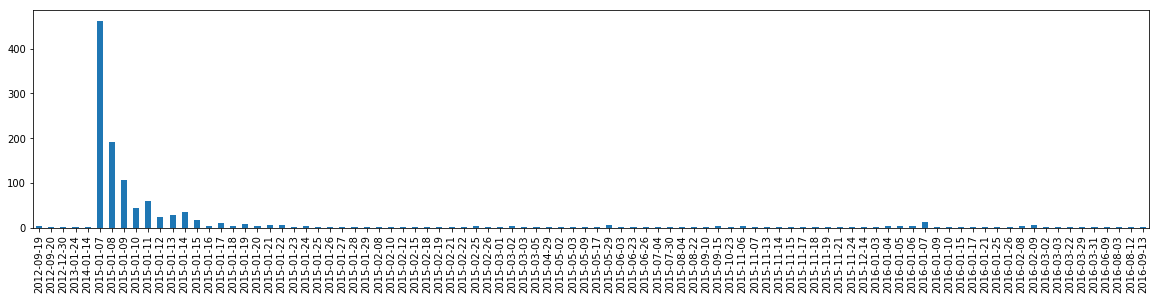

In [17]:
plot_frequency_tags(df_tag, 'day', "#charliehebdo", 100, group_hashtags)

Let us now try this for events that take place every year at the same period, for example Eurovision and Paléo Festival.

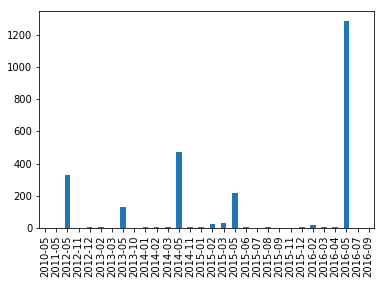

In [20]:
plot_frequency_tags(df_tag, 'month', "#eurovision", 30, group_hashtags)

For Eurovision, we can clearly see a spike each year during the month of may, which is indeed when the contest takes place.

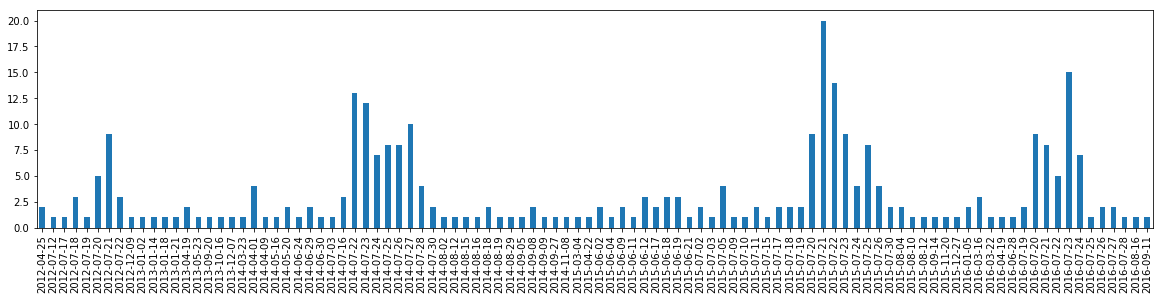

In [23]:
plot_frequency_tags(df_tag, 'day', "#paleo", 100, group_hashtags)

For Paléo Festival, we can again see a spike each year during the end of month of July, but this time we can also see that it lasts about a week.

## 3.2 Geographic event localisation

Here we can use the geographic information of the tweets to determine the location of an event. To do so, we display on a map the geolocation of each tweet that mentions a given hashtag. The following function were implemented in order to create this map.

Now let us try this with Eurovision and Paléo Festival, which were already used as examples previously. As we can see in the maps below, Eurovision is an international event since the geographic repartitions of tweet is quite homogenous over Switzerland. On the other hand, if we look at the hashtag '#paleo', we can quickly see that it takes place in Nyon because there is a very high concentration of tweets about Paléo in that area.

In [90]:
get_map_with_hasthtag("#eurovision", df_tag, group_hashtags)

In [65]:
get_map_with_hasthtag("#paleo", df_tag, group_hashtags)

# 4. Event detection

## 4.1. Filtering out irrelevant hashtags

Currently, we have way too many hashtags and it would be unfeasible run our event detection algorithm on every single one of them. Thus we have to filter out hashtags that are very unlikely to be detected as events by our algorithm.

In [66]:
print("Total number of hashtags : %s" % group_hashtags.shape[0])

Total number of hashtags : 874767


First, we filter our hashtags by keeping only the ones that are used in more than **100** tweets. Then remove hashtags tweeted by less than **50** unique users. By filtering with respect to the number of unique users instead of the total number of tweets, we discard hashtags that were tweeted many times by only a few number of people. This could be the case if one or a few twitter bots tweet some hashtag an insane number of times in a short period.

In [67]:
def get_max_daily_unique_authors(hashtag_dic_days):
    return max(hashtag_dic_days.values())

In [68]:
group_df_filtered = group_hashtags.copy()
group_df_filtered = group_df_filtered[group_df_filtered['tweets_nb'] > 100]
group_df_filtered = group_df_filtered[group_df_filtered['nb_unique_authors'] > 50]

group_df_filtered['max_unique_author_day'] = group_df_filtered.index.map(lambda hashtag: get_max_daily_unique_authors(dic_tag_days.get(hashtag)))
group_df_filtered[group_df_filtered['max_unique_author_day'] > 5].shape[0]

group_df_filtered.shape[0]

4721

Below, we compute the number of unique authors per days for each filtered hashtags. The output is a dictionary with each hashtags as entries. The value of each entry is itself a dictionary with, dates as keys and number of unique authors as values.

In [ ]:
# Compute dictionnary of hashtags occurences per day
dic_tag_days = get_unique_author_per_day(group_df_filtered, "day", df_tag)

# Save dictionnary to file
print('\nSaving dictionnary to file...')
pickle_out = open("../../twitter_dataset/dic_tag_days.pickle","wb")
pickle.dump(dic_tag_days, pickle_out)
pickle_out.close()

In [69]:
# Load dictionnary of hashtags occurences per day from file
pickle_in = open("../../twitter_dataset/dic_tag_days.pickle","rb")
dic_tag_days = pickle.load(pickle_in)
pickle_in.close()

## 4.2. Event Detection algorithm

Below we have our main detection algorithm.
Each function is explained in our code.

In [70]:
def get_event_score(day, dic_hashtag, moving_avg, event_kernel, max_factor=2):
    """Returns the event score for a given day.
       This is obtained by innerproduct between the number of unique authors and the given kernel, 
       and then dividing by the given moving average (which is an average over values around that day).
    """
    # Get the number of unique authors for the given day
    day_value = dic_hashtag.get(str(day), 0)
    
    # If no tweets that day, the score is 0
    if day_value == 0:
        event_score = 0
    else:
        # Compute the inner product of the values with the given kernel centered around the day of interest
        h = int(len(event_kernel) / 2)
        event_inner_prod = 0
        for i in range(-h, h+1):
            d = day + timedelta(i)
            # For the inner product, we limit the values used to max_factor*day_value
            value_i = min(max_factor*day_value, dic_hashtag.get(str(d), 0))
            event_inner_prod += event_kernel[i + h] * min(max_factor*day_value, dic_hashtag.get(str(d), 0))
        
        # Divide the innerproduct by the moving average to get the event score
        event_score = event_inner_prod / max(1, moving_avg)
    
    return event_score

def detect_event(hashtag, dic_tag_days, threshold=4, averaging_window=35):
    """Detect potential events related to the given hashtag. 
       Returns the detected event dates, and an array of event scores for each day in the dataset.
    """
    event_kernel = [0.1, 0.8, 0.1]
    dic_hashtag = dic_tag_days.get(hashtag)
    
    # Create the array containing every day included in the dataset
    dates = np.asarray([DATASET_BEGIN_DATE + timedelta(days=i) for i in range(DATASET_TOTAL_DAYS)])
    
    # Compute the the average and variance for the first moving window
    moving_avg_window_end = DATASET_BEGIN_DATE + timedelta(days=averaging_window - 1)
    moving_avg = get_average(hashtag, dic_tag_days, DATASET_BEGIN_DATE, moving_avg_window_end)
    half_window = int(averaging_window / 2)
        
    # Compute the event score for each day
    event_score = np.zeros(len(dates)) 
    for i in range(half_window, len(dates) - half_window):
        if i != half_window:
            moving_avg_update = (dic_hashtag.get(str(dates[i+half_window]),0) - dic_hashtag.get(str(dates[i-half_window-1]),0)) / averaging_window
            moving_avg = moving_avg + moving_avg_update
        
        event_score[i] = get_event_score(dates[i], dic_hashtag, moving_avg, event_kernel)
        
    # Get the dates at which an event was detected
    event_dates = dates[np.where(event_score >= threshold)]
    event_dates = [str(d) for d in event_dates]
    
    return (event_dates, event_score)

def detect_events(dic_tag_days, threshold=4, averaging_window=35):
    """Detect events from our filtered hashtags. 
       Returns the detected event hashtags with the respecting event dates.
    """
    event_dic = {}
    nb_tags = len(dic_tag_days.keys())
    print("Detecting events...")
    
    for tag_idx, tag in enumerate(dic_tag_days.keys()):
        detected_events = detect_event(tag, dic_tag_days, threshold=threshold, averaging_window=averaging_window)[0]
        
        if len(detected_events) > 0:
            event_dic[tag] = detected_events
        
        sys.stdout.write("\r{0:.2f}%".format((float(tag_idx+1)/nb_tags)*100))
        sys.stdout.flush()
    print("\n")
    
    return event_dic

In [71]:
event_dic = detect_events(dic_tag_days)

print("Events were found for {} hashtags out of {}".format(len(event_dic.keys()), len(dic_tag_days.keys())))

Detecting events...
100.00%

Events were found for 2108 hashtags out of 6197


Here we print 10 event we detected and their dates. Note that there is no particular order for events in our dictionary.

In [76]:
list(event_dic.items())[40:50]

[('#1mai',
  ['2012-05-01', '2013-05-01', '2014-05-01', '2015-05-01', '2016-05-01']),
 ('#beliebers', ['2013-03-22']),
 ('#nosnow', ['2015-12-27', '2015-12-31']),
 ('#coldplay', ['2012-05-26', '2016-06-11', '2016-06-12']),
 ('#lasttweet', ['2012-04-22']),
 ('#lacleman', ['2016-03-26', '2016-08-12']),
 ('#walbel', ['2016-07-01']),
 ('#notte', ['2012-10-28']),
 ('#2', ['2015-10-23']),
 ('#facebook',
  ['2013-09-30',
   '2014-02-20',
   '2014-06-19',
   '2014-12-01',
   '2015-01-27',
   '2015-09-16'])]

Events may span over multiple days, therefore here we decide to group them together if they are close in time.

In [74]:
grouped_event_dic = group_events_by_date(event_dic)

nb_events = np.asarray([len(dates_groups) for dates_groups in grouped_event_dic.values()]).sum()
print("{} different events were found ".format(nb_events))

7028 different events were found 


Here we print 10 event we detected and their dates grouped. We can see that sometime the event span multiple dates.

In [77]:
list(grouped_event_dic.items())[40:50]

[('#1mai',
  [['2012-05-01'],
   ['2013-05-01'],
   ['2014-05-01'],
   ['2015-05-01'],
   ['2016-05-01']]),
 ('#beliebers', ['2013-03-22']),
 ('#nosnow', [['2015-12-27'], ['2015-12-31']]),
 ('#coldplay', [['2012-05-26'], ['2016-06-11', '2016-06-12']]),
 ('#lasttweet', ['2012-04-22']),
 ('#lacleman', [['2016-03-26'], ['2016-08-12']]),
 ('#walbel', ['2016-07-01']),
 ('#notte', ['2012-10-28']),
 ('#2', ['2015-10-23']),
 ('#facebook',
  [['2013-09-30'],
   ['2014-02-20'],
   ['2014-06-19'],
   ['2014-12-01'],
   ['2015-01-27'],
   ['2015-09-16']])]

Here is a visualisation on how our algorithm decides if it detected an event.
For instance, we can look at #christmas. We expect that people will talk progressively more about christmas up to the 25 december. In the graph below, we see this behaviour exactly with a spike on the 25 december. The dashed gray line represent our threashold on the detection. If the score (red line) crosses this threashold, we consider the tag as an event for the given day. We will also plot every dates detected for the hashtag below the plot.

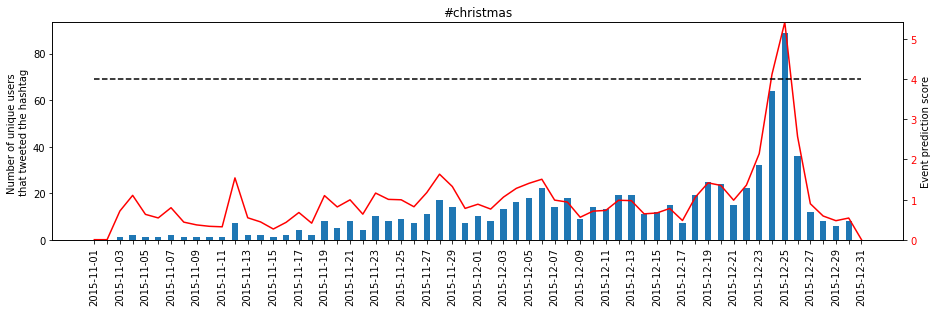

['2012-12-24',
 '2012-12-25',
 '2013-12-24',
 '2013-12-25',
 '2014-12-24',
 '2014-12-25',
 '2015-12-24',
 '2015-12-25']

In [78]:
hashtag = "#christmas"
threshold = 4
(event_dates, event_score) = detect_event(hashtag, dic_tag_days, threshold=threshold)
plot_hashtag_and_event_score(hashtag, event_score, dic_tag_days, date(2015, 11, 1), date(2015, 12, 31), threshold=threshold)
event_dates

This type of event is something unplaned. The number of unique authors goes up suddenly and then decreases progressively.

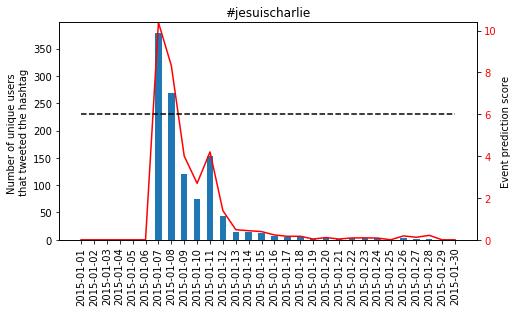

['2015-01-07', '2015-01-08']

In [79]:
hashtag = "#jesuischarlie"
threshold = 6
(event_dates, event_score) = detect_event(hashtag, dic_tag_days, threshold=threshold)
plot_hashtag_and_event_score(hashtag, event_score, dic_tag_days, date(2015, 1, 1), date(2015, 1, 30), threshold=threshold)
event_dates

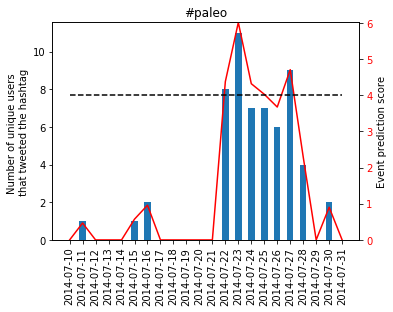

['2014-07-22',
 '2014-07-23',
 '2014-07-24',
 '2014-07-25',
 '2014-07-27',
 '2015-07-20',
 '2015-07-21',
 '2015-07-22',
 '2015-07-23',
 '2016-07-20',
 '2016-07-23',
 '2016-07-24']

In [80]:
hashtag = "#paleo"
threshold = 4
(event_dates, event_score) = detect_event(hashtag, dic_tag_days, threshold=threshold)
plot_hashtag_and_event_score(hashtag, event_score, dic_tag_days, date(2014, 7, 10), date(2014, 7, 31), threshold=threshold)
event_dates

## 4.3. Event localization

We will now try to detect the location of local events. The map below show with a red circle the detected event location.

In [81]:
hashtag = '#paleo'
dates = [datetime.strptime(d, "%Y-%m-%d").date() for d in event_dic[hashtag]]
display_event_map(hashtag, dates, df_tag, group_hashtags)

Detected event location : [ 46.4205    6.20298]
Mean deviation : 0.1562002255639095


In this map, we do not have a local event (which can be seen because of the mean deciation). If we try to estimate the position of the event anyway, we see that the location does not make any sens.

In [82]:
hashtag = '#riprobinwilliams'
dates = [datetime.strptime(d, "%Y-%m-%d").date() for d in event_dic[hashtag]]
display_event_map(hashtag, dates, df_tag, group_hashtags)

Detected event location : [ 46.2956    8.53676]
Mean deviation : 1.1133532124352328


In [83]:
events_locations = get_events_locations(grouped_event_dic, df_tag, group_hashtags, return_mean_std=False)

print("Locations were found for {} events out of {}".format(len(events_locations), len(grouped_event_dic.keys())))

Computing events locations...
100.00%

Locations were found for 317 events out of 2108


Below, we print the local events dates and their location.
Better visualisation will follow.

In [84]:
list(events_locations.items())[0:10]

[('#megeve', [(['2016-07-21'], array([ 45.8    ,   6.56618]))]),
 ('#sdgs', [(['2016-05-24'], array([ 46.2048 ,   6.14319]))]),
 ('#teamom', [(['2014-02-16'], array([ 47.1319 ,   6.29097]))]),
 ('#tvog', [(['2014-11-06'], array([ 47.7571 ,   8.86759]))]),
 ('#carnevale', [(['2014-03-08'], array([ 45.857   ,   8.836925]))]),
 ('#davos',
  [(['2013-01-22', '2013-01-23', '2013-01-24', '2013-01-25'],
    array([ 46.765  ,   9.81838])),
   (['2014-01-21', '2014-01-22', '2014-01-23', '2014-01-24'],
    array([ 46.765  ,   9.81838])),
   (['2015-01-20', '2015-01-21', '2015-01-22', '2015-01-23', '2015-01-24'],
    array([ 46.765  ,   9.81838])),
   (['2015-03-07', '2015-03-08'], array([ 46.765  ,   9.81838])),
   (['2016-01-20', '2016-01-21', '2016-01-22'],
    array([ 46.765  ,   9.81838]))]),
 ('#artbasel2016',
  [(['2016-06-14', '2016-06-15', '2016-06-16'],
    array([ 47.5596 ,   7.58314]))]),
 ('#baselworld2014',
  [(['2014-03-26', '2014-03-27', '2014-03-28', '2014-03-30', '2014-03-31'],


Now if we have a hashtags multiple times at the same location, we can group it as a single event in our map. This way we will not have multiple markers for the same event.

In [85]:
grouped_events_locations = group_by_location(events_locations)
list(grouped_events_locations.items())[0:10]

[('#megeve', [([['2016-07-21']], [45.799999999999997, 6.5661800000000001])]),
 ('#sdgs', [([['2016-05-24']], [46.204799999999999, 6.1431899999999997])]),
 ('#teamom', [([['2014-02-16']], [47.131900000000002, 6.2909699999999997])]),
 ('#tvog', [([['2014-11-06']], [47.757100000000001, 8.8675899999999999])]),
 ('#carnevale',
  [([['2014-03-08']], [45.856999999999999, 8.8369250000000008])]),
 ('#davos',
  [([['2013-01-22', '2013-01-23', '2013-01-24', '2013-01-25'],
     ['2014-01-21', '2014-01-22', '2014-01-23', '2014-01-24'],
     ['2015-01-20', '2015-01-21', '2015-01-22', '2015-01-23', '2015-01-24'],
     ['2015-03-07', '2015-03-08'],
     ['2016-01-20', '2016-01-21', '2016-01-22']],
    [46.765000000000001, 9.8183799999999994])]),
 ('#artbasel2016',
  [([['2016-06-14', '2016-06-15', '2016-06-16']],
    [47.559600000000003, 7.5831400000000002])]),
 ('#baselworld2014',
  [([['2014-03-26', '2014-03-27', '2014-03-28', '2014-03-30', '2014-03-31']],
    [47.559600000000003, 7.5831400000000002

-------------------------
Below is our map for local events. Each marker represent a specific local event. The map is interactive and clicking on a marker will display the hashtag and dates of the event.

In [86]:
get_events_map(grouped_events_locations, event_dic)